# Image Alignment
**Satya Mallick, LearnOpenCV.com**

## Align an image to a template.
![alt text](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_08_image-alignment-using-opencv.jpg "Image Alignment")

## Theory

1. A **Homography** transforms a square to arbitrary quad.

![alt text](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_08_motion-models.jpg "Motion Models")

## Theory

2. Images of two planes are related by a **Homography**
3. We need **4 corresponding points** to estimate Homography


!["Homography Example"](https://learnopencv.com/wp-content/uploads/2023/03/opencv_bootcamp_08_homography-example.jpg)

In [1]:
# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from zipfile import ZipFile
from urllib.request import urlretrieve

%matplotlib inline

##  <font style="color:black">Download Assets</font>

In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

In [3]:
URL = r"https://www.dropbox.com/s/zuwnn6rqe0f4zgh/opencv_bootcamp_assets_NB8.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB8.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

## Step 1: Read Tempalate and Scanned Image

In [4]:
# Read reference image
refFilename = "form.jpg"
print("Reading reference image:", refFilename)
im1 = cv2.imread(refFilename, cv2.IMREAD_COLOR)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

# Read image to be aligned
imFilename = "scanned-form.jpg"
print("Reading image to align:", imFilename)
im2 = cv2.imread(imFilename, cv2.IMREAD_COLOR)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

Reading reference image: form.jpg
Reading image to align: scanned-form.jpg


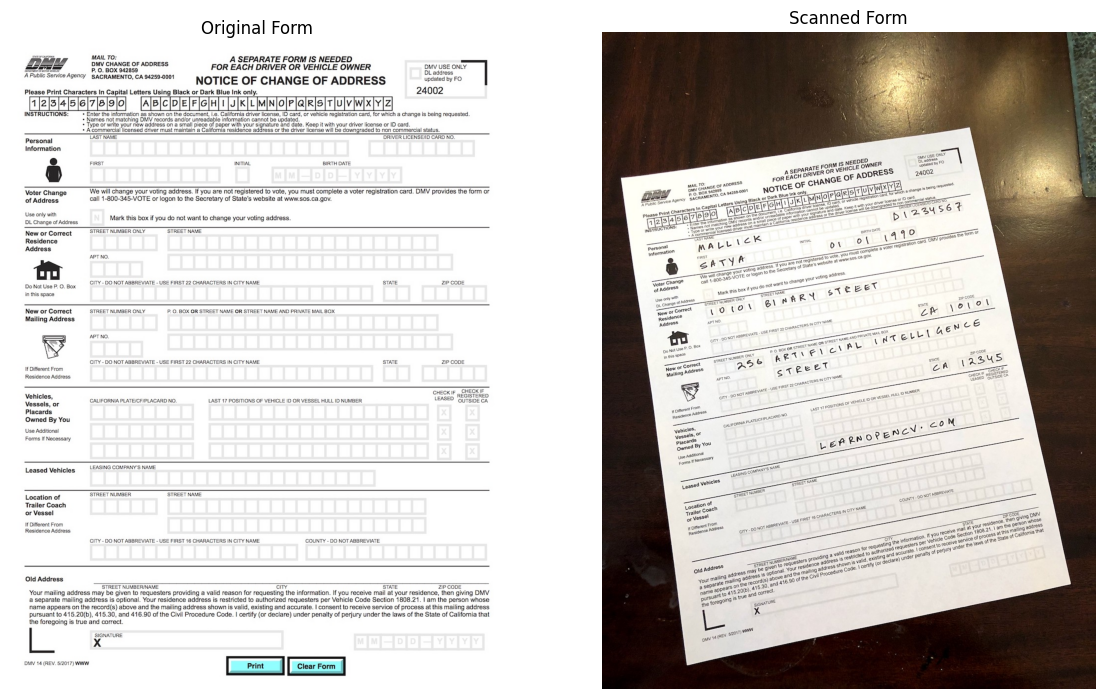

In [16]:
# Display Images

plt.figure(figsize=[14, 10]);
plt.subplot(121); plt.axis('off'); plt.imshow(im1); plt.title("Original Form")
plt.subplot(122); plt.axis('off'); plt.imshow(im2); plt.title("Scanned Form")
plt.show()

## Step 2: Find keypoints in both Images

Think of keypoints as corner points that are stable under image transformations

In [8]:
# Convert images to grayscale
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)


# Detect ORB features and compute descriptors.
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)

# Display
im1_display = cv2.drawKeypoints(im1, keypoints1, outImage=np.array([]),
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

im2_display = cv2.drawKeypoints(im2, keypoints2, outImage=np.array([]),
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# OpenCV ORB 特征检测与描述符计算详解

这段代码使用 OpenCV 的 ORB (Oriented FAST and Rotated BRIEF) 算法来检测图像中的关键点并计算它们的描述符。下面我将详细解释每一部分的功能和作用。

## 1. 图像灰度转换

```python
im1_gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
```

- **作用**：将彩色图像转换为灰度图像
- **原因**：ORB 特征检测通常在单通道灰度图像上进行，因为：
  - 减少计算量（从3通道变为1通道）
  - 大多数特征检测算法是为灰度图像设计的
  - 颜色信息对特征检测通常不是必需的
- `cv2.COLOR_BGR2GRAY`：OpenCV 使用 BGR 色彩空间（不是 RGB），所以转换标志是 BGR2GRAY

## 2. ORB 检测器初始化

```python
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
```

- **ORB_create()**：创建 ORB 检测器对象
- **参数**：
  - `MAX_NUM_FEATURES`：要保留的最大特征点数量（这里设为500）
- **其他可选参数**（未在此代码中使用但很重要）：
  - `nfeatures`：最大特征点数
  - `scaleFactor`：金字塔缩放因子（默认1.2）
  - `nlevels`：金字塔层数（默认8）
  - `edgeThreshold`：边缘阈值
  - `firstLevel`：第一层金字塔级别
  - `WTA_K`：产生每个BRIEF描述符的像素点数
  - `scoreType`：特征点评分类型（HARRIS或FAST）
  - `patchSize`：BRIEF描述符的邻域大小

## 3. 特征检测与描述符计算

```python
keypoints1, descriptors1 = orb.detectAndCompute(im1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2_gray, None)
```

- **detectAndCompute()**：同时检测关键点并计算描述符
  - 输入参数：
    - 第一个参数：输入图像（灰度图）
    - 第二个参数：掩模图像（None表示不使用掩模）
  - 返回值：
    - `keypoints`：检测到的关键点列表，每个关键点包含：
      - `pt`：坐标(x,y)
      - `size`：特征区域直径
      - `angle`：特征方向（度）
      - `response`：响应强度
      - `octave`：金字塔层级
      - `class_id`：关键点ID
    - `descriptors`：关键点描述符矩阵（N×32的numpy数组，N是关键点数量）

## 4. 关键点可视化

```python
im1_display = cv2.drawKeypoints(im1, keypoints1, outImage=np.array([]),
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
im2_display = cv2.drawKeypoints(im2, keypoints2, outImage=np.array([]),
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
```

- **drawKeypoints()**：在图像上绘制检测到的关键点
  - 参数说明：
    - 第一个参数：原始图像
    - 第二个参数：关键点列表
    - `outImage`：输出图像（np.array([])表示创建新图像）
    - `color`：关键点颜色（BGR格式，这里是红色）
    - `flags`：绘制标志：
      - `cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS`：绘制带方向和大小的圆
      - 其他选项：`DEFAULT`、`DRAW_OVER_OUTIMG`、`NOT_DRAW_SINGLE_POINTS`等
- **输出效果**：
  - 每个关键点会显示为一个圆
  - 圆的大小表示特征区域大小
  - 圆的径向线表示特征方向

## ORB 算法特点

1. **FAST 关键点检测**：
   - 快速检测角点特征
   - 通过像素强度比较确定特征点

2. **BRIEF 描述符**：
   - 二进制描述符（计算快、匹配快）
   - 对旋转敏感（所以ORB添加了方向不变性）

3. **方向不变性**：
   - 通过图像矩计算特征方向
   - 使描述符对图像旋转具有鲁棒性

4. **尺度不变性**：
   - 通过图像金字塔实现
   - 可以检测不同尺度的特征

## 典型应用场景

1. 图像匹配与拼接
2. 目标识别
3. 3D重建
4. 视觉SLAM
5. 增强现实

这段代码通常是图像匹配流程的第一步，后续可能会使用BFMatcher或FLANN进行特征匹配，然后计算单应性矩阵等操作。

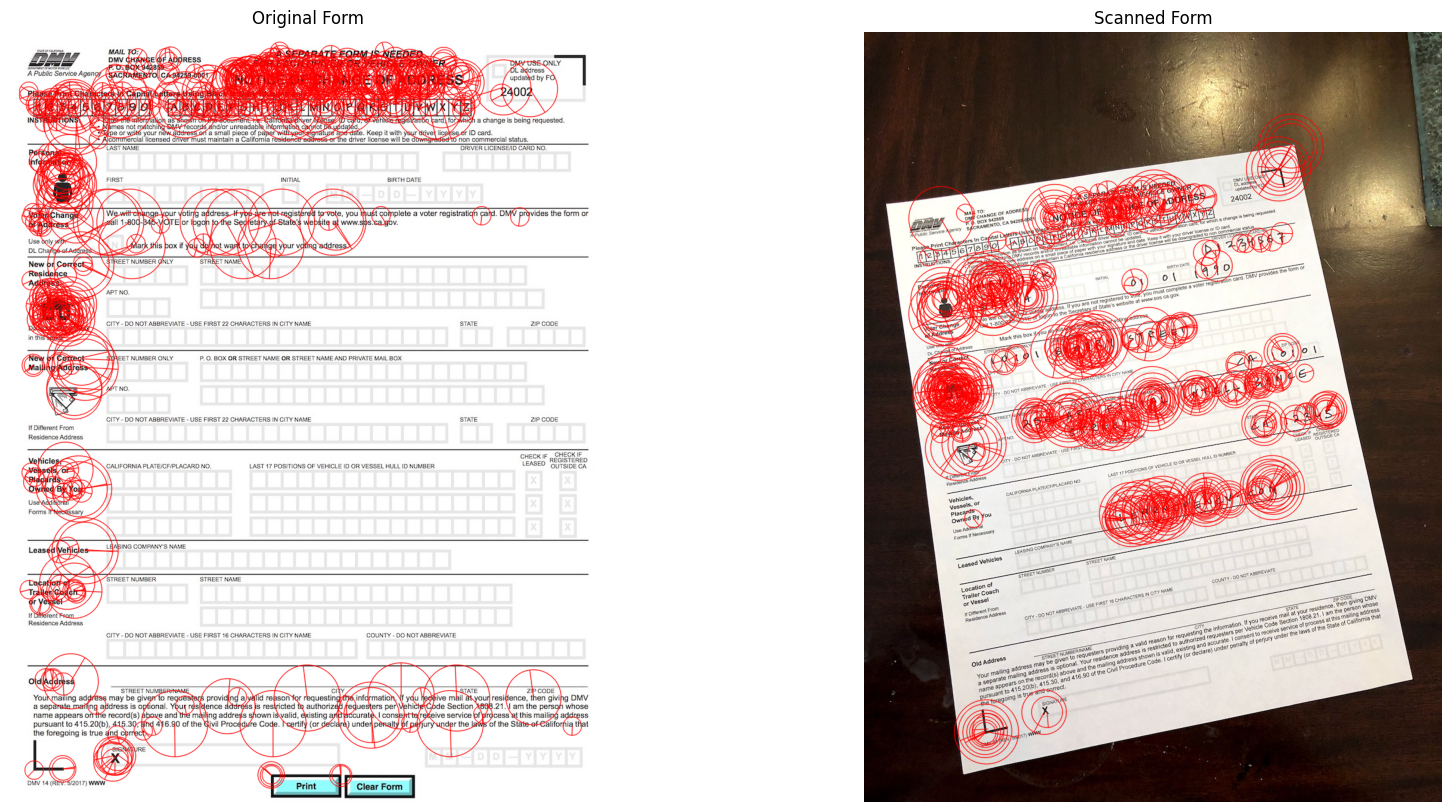

In [9]:
plt.figure(figsize=[20,10])
plt.subplot(121); plt.axis('off'); plt.imshow(im1_display); plt.title("Original Form");
plt.subplot(122); plt.axis('off'); plt.imshow(im2_display); plt.title("Scanned Form");
plt.show()

## Step 3 : Match keypoints in the two image

In [10]:
# Match features.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# Converting to list for sorting as tuples are immutable objects.
matches = list(matcher.match(descriptors1, descriptors2, None))

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]

# OpenCV 特征匹配代码详解

这段代码实现了使用 OpenCV 进行特征匹配的过程，主要包括暴力匹配器创建、特征匹配、匹配结果排序和筛选优质匹配。下面我将详细解释每一部分的功能和作用。

## 1. 创建匹配器对象

```python
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
```

- **作用**：创建一个暴力匹配器(Brute-Force Matcher)对象
- **参数**：
  - `cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING`：指定使用汉明距离(Hamming distance)作为相似度度量的暴力匹配器
- **细节**：
  - ORB描述符是二进制特征（不像SIFT/SURF是浮点数向量），所以需要使用汉明距离
  - 汉明距离计算两个二进制串之间的不同位数
  - 暴力匹配器会将第一个图像中的每个描述符与第二个图像中的所有描述符进行比较

## 2. 执行特征匹配

```python
matches = list(matcher.match(descriptors1, descriptors2, None))
```

- **match()方法**：执行描述符匹配
  - 参数：
    - `descriptors1`：第一幅图像的特征描述符
    - `descriptors2`：第二幅图像的特征描述符
    - `None`：可选的掩模参数（这里不使用）
  - 返回值：
    - 返回DMatch对象的列表，每个DMatch包含：
      - `distance`：两个描述符之间的距离（越小越相似）
      - `queryIdx`：第一幅图像中描述符的索引
      - `trainIdx`：第二幅图像中描述符的索引
      - `imgIdx`：训练图像的索引
- **转换为list**：
  - 将匹配结果转换为列表以便后续排序（原始可能是元组或其他不可变对象）

## 3. 按匹配质量排序

```python
matches.sort(key=lambda x: x.distance, reverse=False)
```

- **sort()方法**：对匹配结果进行排序
  - `key=lambda x: x.distance`：按照DMatch对象的distance属性排序
  - `reverse=False`：升序排列（距离小的排在前面，表示匹配质量更好）
- **效果**：
  - 排序后，最佳匹配（距离最小）会排在列表最前面
  - 质量差的匹配（距离大）会排在后面

## 4. 筛选优质匹配

```python
numGoodMatches = int(len(matches) * 0.1)
matches = matches[:numGoodMatches]
```

- **筛选策略**：
  - 保留前10%的匹配（`len(matches) * 0.1`）
  - 只保留距离最小的那些匹配
- **目的**：
  - 去除质量差的匹配（距离大的匹配）
  - 提高后续处理（如计算单应性矩阵）的准确性
- **替代方案**：
  - 也可以使用固定距离阈值，如 `matches = [m for m in matches if m.distance < 50]`
  - 或使用比率测试（Ratio Test）来筛选更稳定的匹配

## 匹配过程可视化（补充代码）

虽然原代码中没有，但通常会添加可视化代码来检查匹配质量：

```python
# 绘制匹配结果
matched_vis = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

# 显示结果
cv2.imshow("Matched Keypoints", matched_vis)
cv2.waitKey(0)
cv2.destroyAllWindows()
```

## 典型应用场景

1. **图像拼接**：匹配不同视角的图像特征
2. **目标识别**：匹配目标图像和场景图像
3. **运动追踪**：匹配连续帧中的特征点
4. **3D重建**：匹配多视图中的对应点

## 改进建议

1. **使用比率测试(Ratio Test)**：
   ```python
   # 使用knnMatch获取前两个最佳匹配
   matches = matcher.knnMatch(descriptors1, descriptors2, k=2)
   
   # 应用比率测试
   good_matches = []
   for m,n in matches:
       if m.distance < 0.75*n.distance:
           good_matches.append(m)
   ```

2. **使用RANSAC过滤异常值**：
   ```python
   # 提取匹配点的位置
   src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
   dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
   
   # 使用RANSAC计算单应性矩阵并过滤异常值
   H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
   
   # 只保留inlier匹配
   matches = [m for i,m in enumerate(matches) if mask[i]]
   ```

这段代码是特征匹配的基础实现，在实际应用中通常需要结合上述改进方法来提高匹配的鲁棒性。

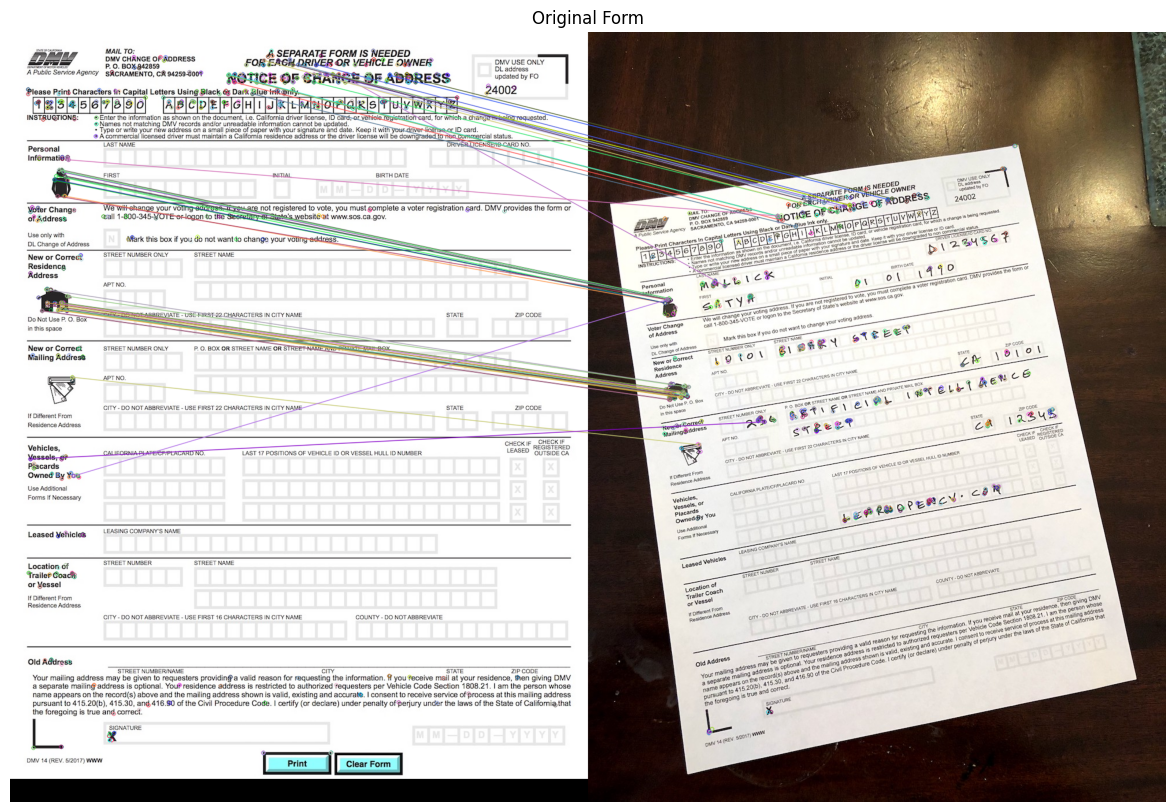

In [24]:
# Draw top matches
im_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)

plt.figure(figsize=[16, 10])
plt.imshow(im_matches);plt.axis("off");plt.title("Original Form")
plt.show()

## Step 4:  Find Homography



In [12]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

# `cv2.findHomography()` 函数详解

## 1. 函数作用

`cv2.findHomography()` 是 OpenCV 中用于计算两幅图像之间单应性矩阵（Homography Matrix）的关键函数，主要应用于：

1. **图像配准**：将两幅不同视角拍摄的图像对齐
2. **全景拼接**：将多幅图像拼接成全景图
3. **透视矫正**：将倾斜拍摄的文档图像矫正为正面视角
4. **增强现实**：将虚拟物体投影到真实场景中

## 2. 函数参数

```python
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)
```

- **points2**：源图像中的点集（待变换的图像点）
- **points1**：目标图像中的点集（参考图像点）
- **cv2.RANSAC**：使用RANSAC算法来鲁棒地估计单应性矩阵
- **返回值**：
  - **h**：3×3的单应性矩阵
  - **mask**：标记哪些点是内点（inliers）的掩码

## 3. 数学原理

### 3.1 单应性变换

单应性变换是投影变换的一种，可以用3×3矩阵H表示：

$$
\begin{bmatrix}
x' \\ y' \\ 1
\end{bmatrix}
= H 
\begin{bmatrix}
x \\ y \\ 1
\end{bmatrix}
=\begin{bmatrix}
h_{11} & h_{12} & h_{13} \\
h_{21} & h_{22} & h_{23} \\
h_{31} & h_{32} & h_{33}
\end{bmatrix}
\begin{bmatrix}
x \\ y \\ 1
\end{bmatrix}
$$

其中(x,y)是源图像点，(x',y')是目标图像点，变换后的坐标为：

$$
x'' = \frac{h_{11}x + h_{12}y + h_{13}}{h_{31}x + h_{32}y + h_{33}}
$$
$$
y'' = \frac{h_{21}x + h_{22}y + h_{23}}{h_{31}x + h_{32}y + h_{33}}
$$

### 3.2 求解方法

1. **直接线性变换(DLT)**：
   - 需要至少4对匹配点
   - 构建方程组 Ah=0，通过SVD求解

2. **RANSAC（随机抽样一致）**：
   - 随机选择最小点集（4对点）计算H
   - 计算所有点的投影误差
   - 选择内点最多的模型
   - 用所有内点重新估计H

## 4. 实际应用示例

```python
# 计算单应性矩阵
h, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# 应用单应性变换
height, width = img1.shape[:2]
warped = cv2.warpPerspective(img2, h, (width, height))

# 可视化内点
matchesMask = mask.ravel().tolist()
```

## 5. 关键参数

- **RANSAC阈值**（如5.0）：决定点是否被视为内点的距离阈值
- **最大迭代次数**：控制RANSAC的计算时间
- **置信度**：影响RANSAC停止条件

## 6. 注意事项

1. 输入点对需要是**浮点型numpy数组**
2. 点对数量**至少4对**才能计算单应性
3. RANSAC能有效**去除误匹配**，提高鲁棒性
4. 单应性矩阵假设场景是**平面**或**相机纯旋转**拍摄

这个函数是计算机视觉中实现图像对齐和拼接的基础工具，理解其原理对开发相关应用非常重要。

## Step 5: Warp image

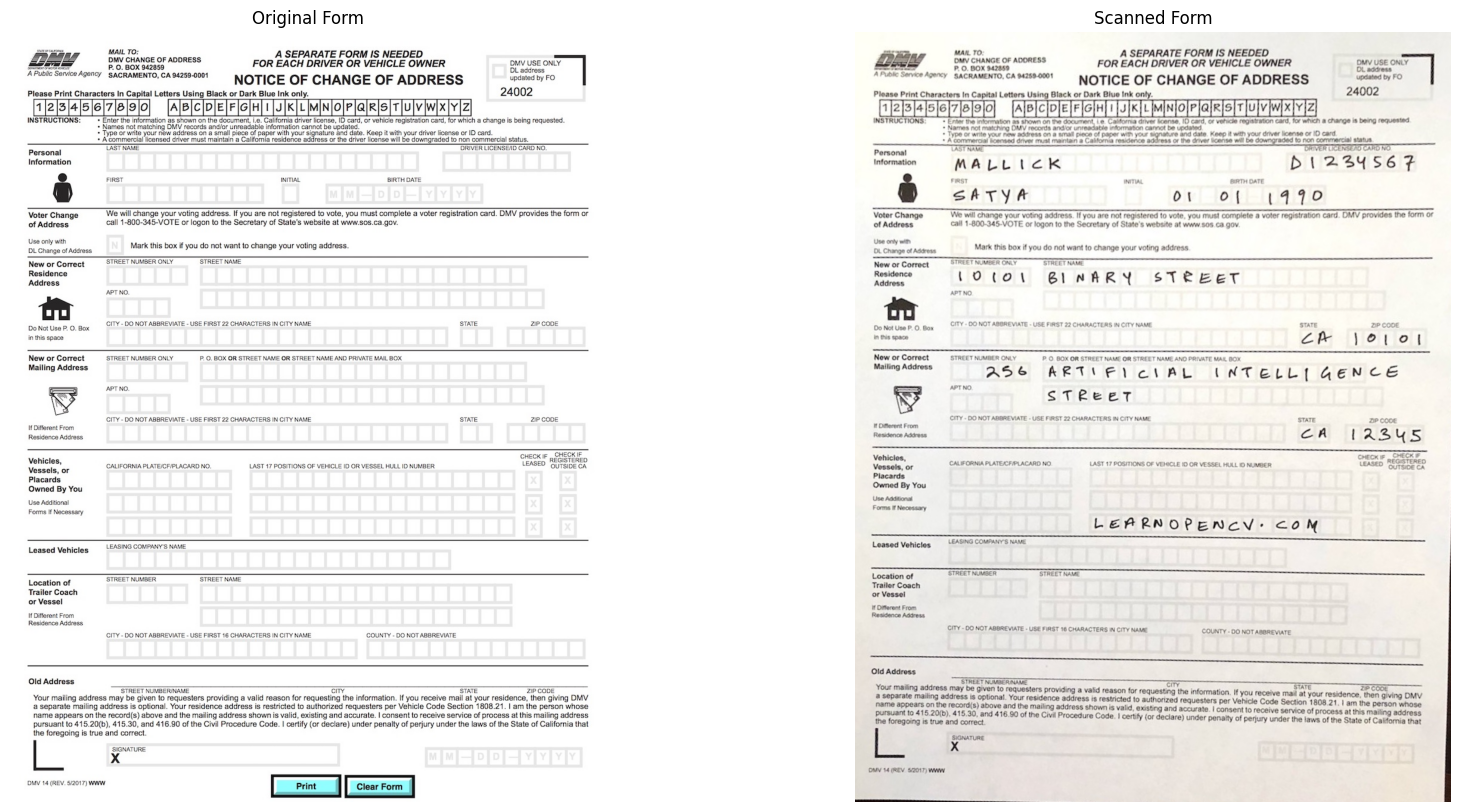

In [13]:
# Use homography to warp image
height, width, channels = im1.shape
im2_reg = cv2.warpPerspective(im2, h, (width, height))

# Display results
plt.figure(figsize=[20, 10])
plt.subplot(121);plt.imshow(im1);    plt.axis("off");plt.title("Original Form")
plt.subplot(122);plt.imshow(im2_reg);plt.axis("off");plt.title("Scanned Form")
plt.show()